# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1nQTkcuThzQBnuuG4fI3RIo_QbDPukPzI?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

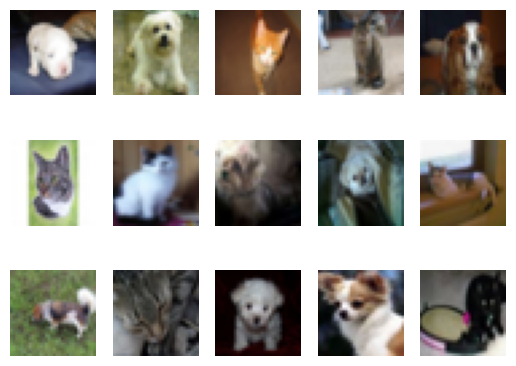

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print("Number of training examples is:", len(train_loader))
print("Number of validation examples is:", len(val_loader))
print("Number of test examples is:", len(test_loader))


Number of training examples is: 8000
Number of validation examples is: 2000
Number of test examples is: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

--> A validation set helps us choose the best set of hyperparameters for our model.
If we judge the performance of our models using the train set loss/error, we will be selecting the model that has best "memorized"/overfitted to the training data. We want to avoid this because this model, and its hyperparamters, may not generalize/perform well to new data. This is why we use a new set of data (completely different than the testing data) to evaluate the performance of our models, and identify the best performing model and its set of hyperparameters.  

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

--> The default values of batch_size is 64, learning_rate is 0.01, num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs = 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42175, Train loss: 0.6739584221839905 |Validation err: 0.3735, Validation loss: 0.6597428098320961
Epoch 2: Train err: 0.370375, Train loss: 0.6481951870918274 |Validation err: 0.372, Validation loss: 0.6535057723522186
Epoch 3: Train err: 0.348875, Train loss: 0.6313568320274353 |Validation err: 0.354, Validation loss: 0.6231604143977165
Epoch 4: Train err: 0.339, Train loss: 0.6142055282592773 |Validation err: 0.3615, Validation loss: 0.6322651784867048
Epoch 5: Train err: 0.328875, Train loss: 0.6017347416877746 |Validation err: 0.33, Validation loss: 0.6109724640846252
Finished Training
Total time elapsed: 28.18 seconds


# List of files

*   model_small_bs64_lr0.01_epoch0 : contains model's updated parameters after first epoch

*   model_small_bs64_lr0.01_epoch1:  contains model's updated parameters after second epoch

*   model_small_bs64_lr0.01_epoch2:  contains model's updated parameters after third epoch

*   model_small_bs64_lr0.01_epoch3:  contains model's updated parameters after fourth epoch

*   model_small_bs64_lr0.01_epoch4:  contains model's updated parameters after fifth epoch

*   model_small_bs64_lr0.01_epoch4_train_err.csv : contains model's training error after each epoch

*   model_small_bs64_lr0.01_epoch4_train_loss.csv : contains model's training loss after each epoch

*   model_small_bs64_lr0.01_epoch4_val_err.csv : contains model's validation error after each epoch

*   model_small_bs64_lr0.01_epoch4_val_loss.csv : contains model's validation loss after each epoch


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.315125, Train loss: 0.5904877288341522 |Validation err: 0.3235, Validation loss: 0.6042896267026663
Epoch 2: Train err: 0.307625, Train loss: 0.5816457393169403 |Validation err: 0.3255, Validation loss: 0.6062043830752373
Epoch 3: Train err: 0.301625, Train loss: 0.577788302898407 |Validation err: 0.326, Validation loss: 0.5967895407229662
Epoch 4: Train err: 0.301375, Train loss: 0.5726792001724244 |Validation err: 0.331, Validation loss: 0.6056416649371386
Epoch 5: Train err: 0.293875, Train loss: 0.5648284223079681 |Validation err: 0.315, Validation loss: 0.5962892435491085
Epoch 6: Train err: 0.29, Train loss: 0.5601351919174195 |Validation err: 0.318, Validation loss: 0.5947511838749051
Epoch 7: Train err: 0.2865, Train loss: 0.560348200082779 |Validation err: 0.314, Validation loss: 0.5843359939754009
Epoch 8: Train err: 0.289, Train loss: 0.5562419195175171 |Validation err: 0.3055, 

Small_net took 171.85 seconds to train. Large_net took 186.01 seconds to train. Large_net took longer to train because the network itself is larger and therefore requires more time to train the many parameters it contains.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small


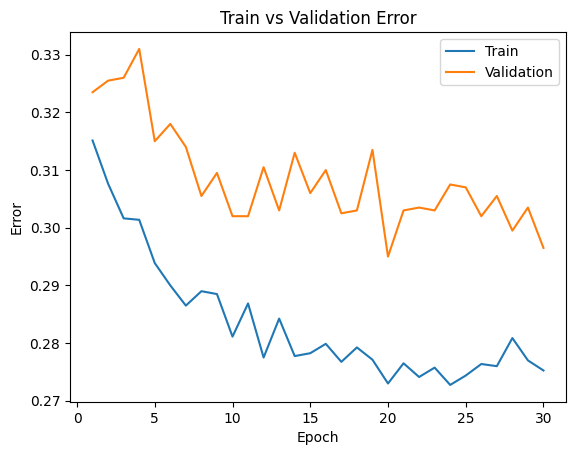

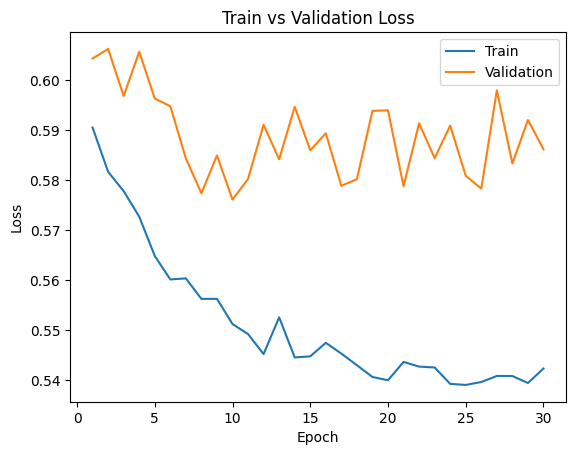

large


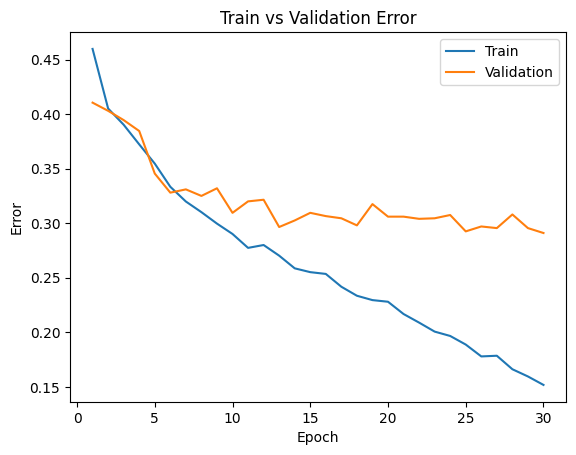

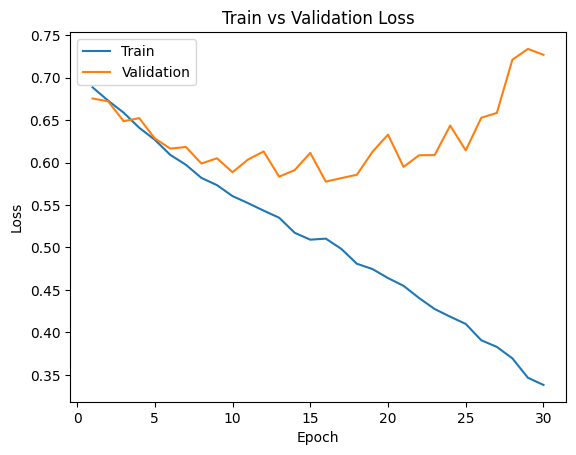

In [ ]:
for name in ["small", "large"]:
  print(name)
  model_path = get_model_name(name, batch_size= 64, learning_rate= 0.01, epoch=29)
  plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For both small_net and large_net, the training curve decreases as the number of epochs increases. However for small_net, the training curve initially decreases rapidly and then begins to flatten out while for large_net the training curve decreases roughly linearly. It seems that both small_net and large_net have begun to overfit since after initially decreasing, their validation loss has begun to increase as the number of epochs increased.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205240249633 |Validation err: 0.491, Validation loss: 0.6929903626441956
Epoch 2: Train err: 0.50225, Train loss: 0.6930275959968567 |Validation err: 0.491, Validation loss: 0.6924116853624582
Epoch 3: Train err: 0.487375, Train loss: 0.6922533192634582 |Validation err: 0.4765, Validation loss: 0.6920256782323122
Epoch 4: Train err: 0.448625, Train loss: 0.6916869778633118 |Validation err: 0.4515, Validation loss: 0.6913820039480925
Epoch 5: Train err: 0.44225, Train loss: 0.6910718841552734 |Validation err: 0.4415, Validation loss: 0.6910950187593699
Epoch 6: Train err: 0.44025, Train loss: 0.690375777721405 |Validation err: 0.437, Validation loss: 0.6905075293034315
Epoch 7: Train err: 0.43825, Train loss: 0.68955340051651 |Validation err: 0.434, Validation loss: 0.6896947957575321
Epoch 8: Train err: 0.439, Train loss: 0.6884737343788147 |Validation err: 0.434, 

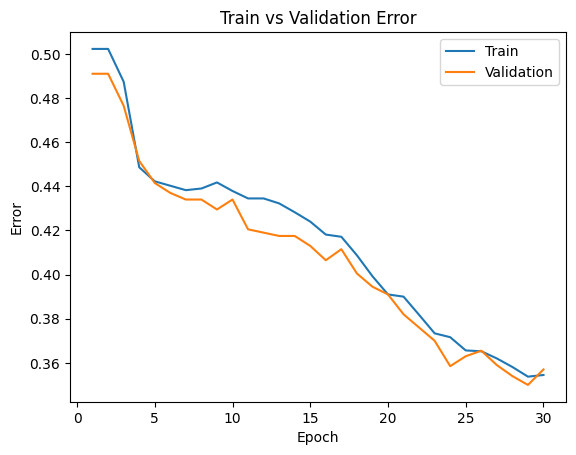

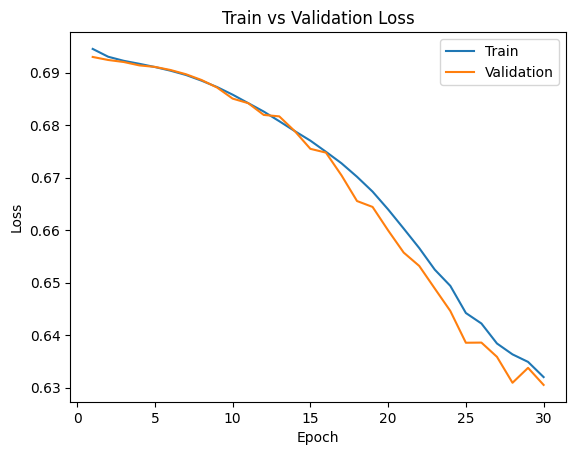

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
model_path = get_model_name("large", batch_size= 64, learning_rate= 0.001, epoch=29)
plot_training_curve(model_path)

Lowering the learning rate to 0.001 caused large_net to take longer to train (189.89 seconds as opposed to 186.01 seconds with a learning rate of 0.01). Lowering the learning rate causes the model to take longer [more epochs] to converge to an optimal solution. This is why after 30 epochs, the model is still underfitting the data.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

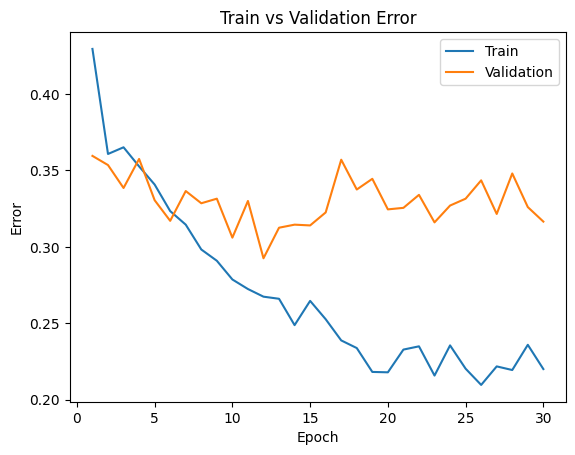

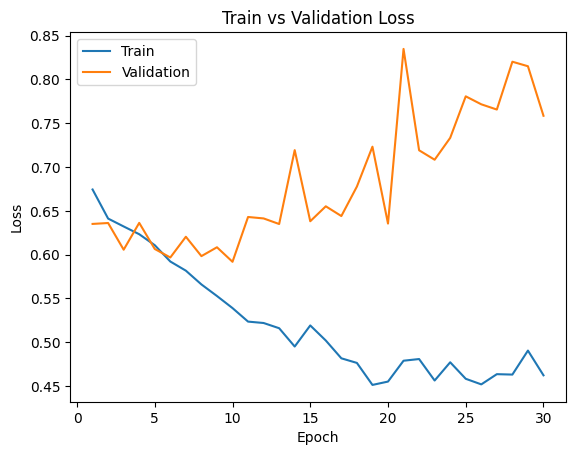

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
model_path = get_model_name("large", batch_size= 64, learning_rate= 0.1, epoch=29)
plot_training_curve(model_path)

Increasing the learning rate to 0.1 caused large_net to take a shorter amount of time to train (184.97 seconds as opposed to 186.01 seconds with a learning rate of 0.01). Increasing the learning rate causes the model to take a shorter amount of time [less epochs] to converge to an optimal solution. This is why after 30 epochs, the model is blatantly overfitting the data.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

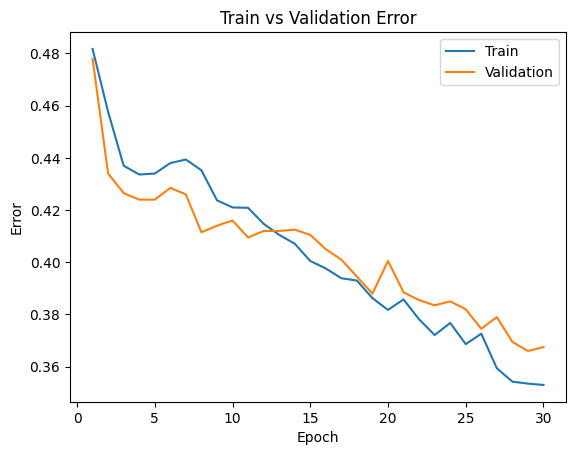

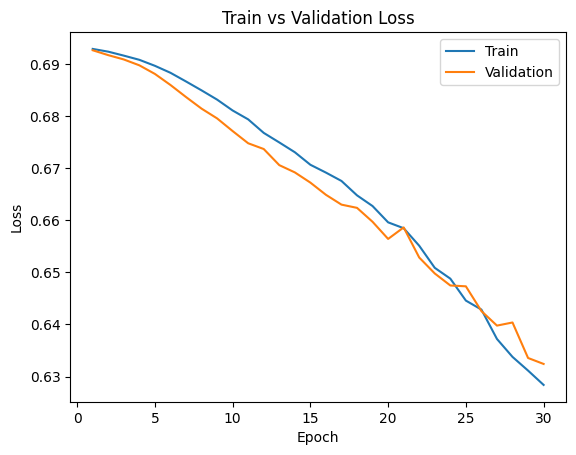

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 512)
model_path = get_model_name("large", batch_size= 512, learning_rate= 0.01, epoch=29)
plot_training_curve(model_path)

Increasing the batch size to 512 caused large_net to take a shorter amount of time to train (163.67 seconds as opposed to 186.01 seconds with a batch size of 64) since we are decreasing the number of iterations. Increasing the batch size causes the model to take more epochs to converge to an optimal solution (since we are updating our parameters less frequently). This is why after 30 epochs, the model is underfitting the data.    

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

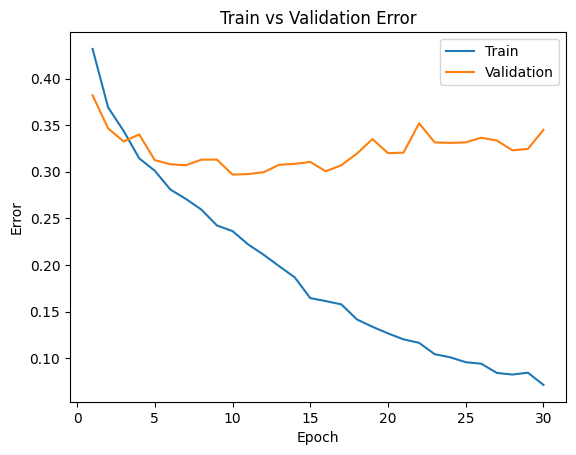

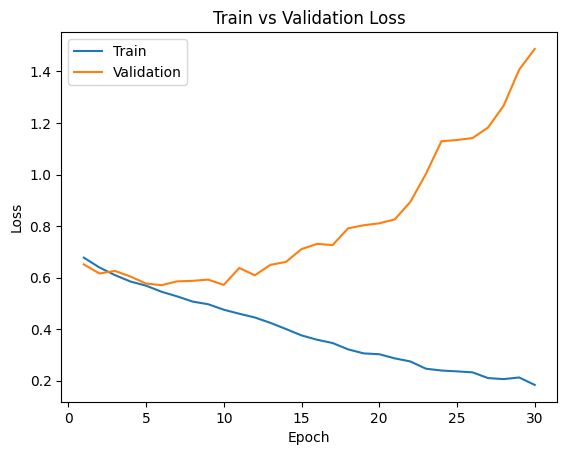

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 16)
model_path = get_model_name("large", batch_size= 16, learning_rate= 0.01, epoch=29)
plot_training_curve(model_path)

Decreasing the batch size to 16 caused large_net to take a longer amount of time to train (273.46 seconds as opposed to 186.01 seconds with a batch size of 64) since we are increasing the number of iterations. Decreasing the batch size causes the model to take less epochs to converge to an optimal solution (since we are updating our parameters more frequently). This is why after 30 epochs, the model is overfitting the data.    

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

To improve validation accuracy, I will choose:

*  network : Large_net since a larger network with more parameters would be able to better model the data (and hence improve the validation accuracy)

* batch_size: 200, the model overfit when the batch_size was 16 and 64 and underfit when the batch_size was 512; so I will choose a batch_size in the middle

* learning_rate: 0.005,  the model overfit when the learning_rate was 0.1 and   0.01 and underfit when the learning_rate was 0.001. Therefore I will choose a learning_rate in the middle

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.475375, Train loss: 0.6927838951349259 |Validation err: 0.455, Validation loss: 0.6923131823539734
Epoch 2: Train err: 0.4465, Train loss: 0.6919411540031433 |Validation err: 0.4395, Validation loss: 0.6909676313400268
Epoch 3: Train err: 0.434375, Train loss: 0.6908130094408989 |Validation err: 0.423, Validation loss: 0.6895093500614167
Epoch 4: Train err: 0.43225, Train loss: 0.6893074855208396 |Validation err: 0.418, Validation loss: 0.6870581448078156
Epoch 5: Train err: 0.437, Train loss: 0.6872320279479027 |Validation err: 0.418, Validation loss: 0.6840827465057373
Epoch 6: Train err: 0.432, Train loss: 0.6849692359566688 |Validation err: 0.41, Validation loss: 0.6809950172901154
Epoch 7: Train err: 0.426875, Train loss: 0.6825480088591576 |Validation err: 0.4125, Validation loss: 0.6784005224704742
Epoch 8: Train err: 0.420625, Train loss: 0.6800568640232086 |Validation err: 0.413, 

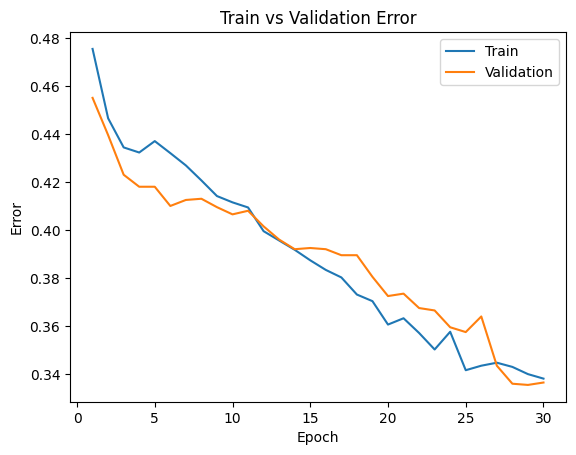

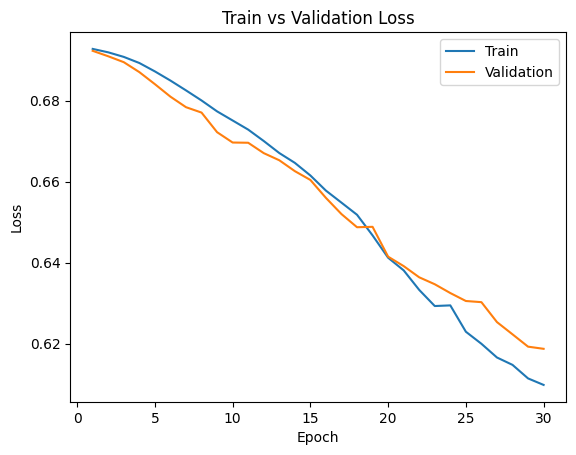

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 200, learning_rate= 0.005)
model_path = get_model_name("large", batch_size= 200, learning_rate= 0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

To improve validation accuracy, I will choose:

*  network : Large_net since a larger network with more parameters would be able to better model the data (and hence improve the validation accuracy)

* batch_size: 75, To prevent underfitting, I will decrease the batch_size to 75.  

* learning_rate: 0.0065 ,the model underfit when the learning_rate was 0.005. Therefore I will increase the learning_rate to try to prevent underfitting.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.449875, Train loss: 0.6917314952779039 |Validation err: 0.432, Validation loss: 0.6885273566952458
Epoch 2: Train err: 0.43825, Train loss: 0.6862339672641219 |Validation err: 0.416, Validation loss: 0.6805555710086116
Epoch 3: Train err: 0.41525, Train loss: 0.6784003187562818 |Validation err: 0.4115, Validation loss: 0.6704727764482852
Epoch 4: Train err: 0.4025, Train loss: 0.6704485873195613 |Validation err: 0.4005, Validation loss: 0.6633128082310712
Epoch 5: Train err: 0.387625, Train loss: 0.6615958325216703 |Validation err: 0.387, Validation loss: 0.6534984928590281
Epoch 6: Train err: 0.36875, Train loss: 0.6486506200282374 |Validation err: 0.381, Validation loss: 0.6430256675790857
Epoch 7: Train err: 0.366, Train loss: 0.6390878062381923 |Validation err: 0.3605, Validation loss: 0.6354762955948159
Epoch 8: Train err: 0.353, Train loss: 0.6272036043282981 |Validation err: 0.352, 

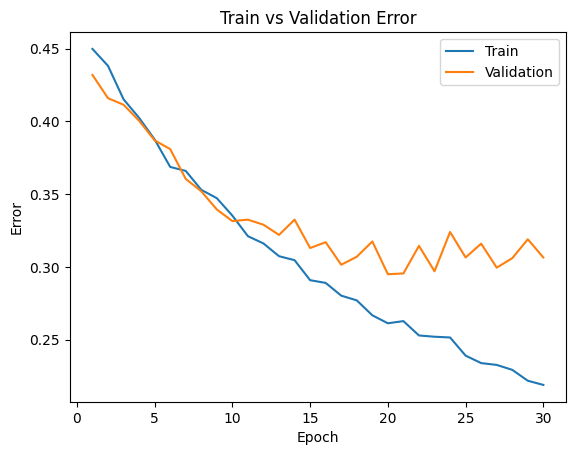

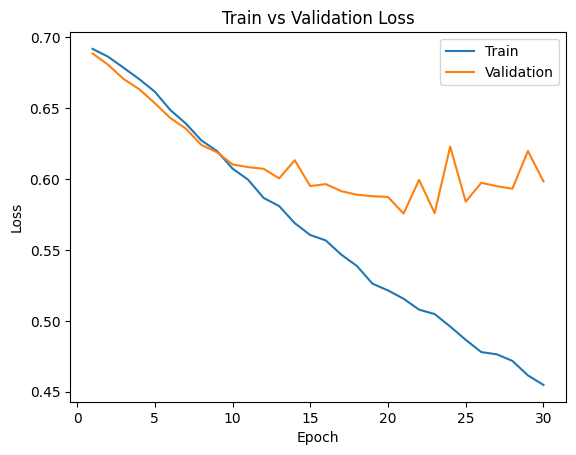

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 75, learning_rate= 0.0065)
model_path = get_model_name("large", batch_size= 75, learning_rate= 0.0065, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=75, learning_rate=0.0065, epoch=21)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I ignored models that underfit to the data. I then selected model checkpoints where the validation loss "dipped" (right before the validation loss would start to increase as epochs increased). This would ensure that the model checkpoint I choose, would not overfit to the data. I then selected the model checkpoint that had the lowest validation error, which happened to be the model in part (a).

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=75)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.BCEWithLogitsLoss()
testerror,testlosss = evaluate(net,test_loader,criterion)
print("Test error :", testerror*100, "%")

Test error : 31.0 %


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error (31%) is higher than the validation error (29.55%). The test error is expected to be higher because the model I chose was selected based on its performance on the validation data. Therefore, its performance on a completetly new set of data (i.e. test data) is likely to worsen.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only used the test data set at the very end, because the test data is only meant to be used to evaluate the performance of our final model. We want to use the test data as little as possible to prevent our model from learning from the test data during training. This will ensure that the results we recieve during testing are an unbiased evaluation of the models performance on new data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423875, Train loss: 0.6766274277120828 |Validation err: 0.417, Validation loss: 0.6668042778968811
Epoch 2: Train err: 0.393, Train loss: 0.6598115477710962 |Validation err: 0.407, Validation loss: 0.6603277787566185
Epoch 3: Train err: 0.382125, Train loss: 0.6510603558272123 |Validation err: 0.3945, Validation loss: 0.6552705571055413
Epoch 4: Train err: 0.373375, Train loss: 0.6442947071045637 |Validation err: 0.399, Validation loss: 0.6532048851251602
Epoch 5: Train err: 0.361625, Train loss: 0.6389438331127166 |Validation err: 0.387, Validation loss: 0.6490699738264084
Epoch 6: Train err: 0.3575, Train loss: 0.6331876620650292 |Validation err: 0.385, Validation loss: 0.647820970416069
Epoch 7: Train err: 0.351625, Train loss: 0.6285250369459391 |Validation err: 0.3795, Validation loss: 0.6462896734476089
Epoch 8: Train err: 0.344375, Train loss: 0.6237884279340505 |Validation err: 0.3

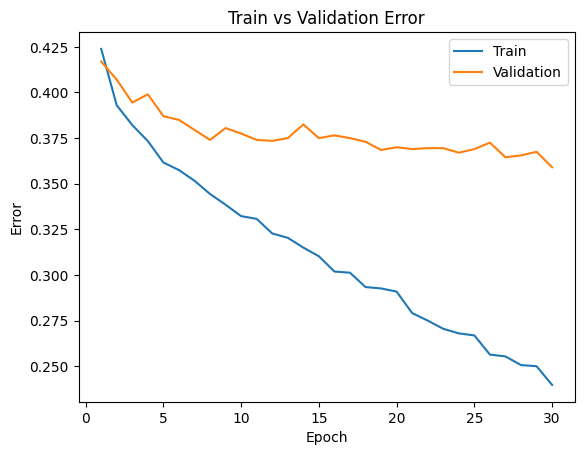

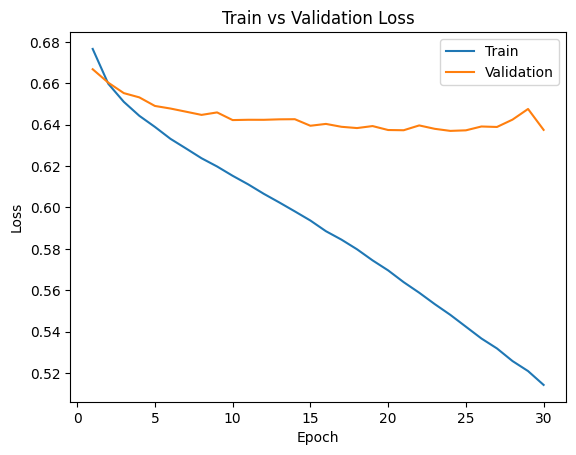

In [ ]:
# defining a 2-layer network
class twoLayerANN(nn.Module):
  def __init__(self):
    super(twoLayerANN, self).__init__()
    self.name = "annModel"
    self.layer1 = nn.Linear(3 * 32 * 32, 500) # CIFAR-10 images are 32 by 32 pixels
    self.layer2 = nn.Linear(500,1)
  def forward(self,img):
    flattened = img.view(-1,3 * 32 * 32) # we have 3 color channels instead of one
    activation1 = self.layer1(flattened)
    activation1 = F.relu(activation1)
    activation2 = self.layer2(activation1)
    return activation2.squeeze(1) # have to squeeze output to return a 1-dimensional tensor

annModel = twoLayerANN()

# training model
train_net(annModel, batch_size= 50, learning_rate= 0.0007)
model_path = get_model_name("annModel", batch_size= 50, learning_rate= 0.0007, epoch=29)
plot_training_curve(model_path)


In [ ]:
# loading test data
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=75)

# testing model
criterion = nn.BCEWithLogitsLoss()
testerror,testlosss = evaluate(annModel,test_loader,criterion)
print("Test error :", testerror*100, "%")

Files already downloaded and verified
Files already downloaded and verified
Test error : 34.4 %


My best CNN model is better than the 2-Layer ANN model that I tuned. The test error of my CNN model was 31% while the test error of my 2-Layer ANN is 34.4%.